In [1]:
import sys
sys.path.append("../")
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import math
from utils.toy_dataset import GaussianMixture
from torch.optim.lr_scheduler import CosineAnnealingLR

## Parameter of the distribution

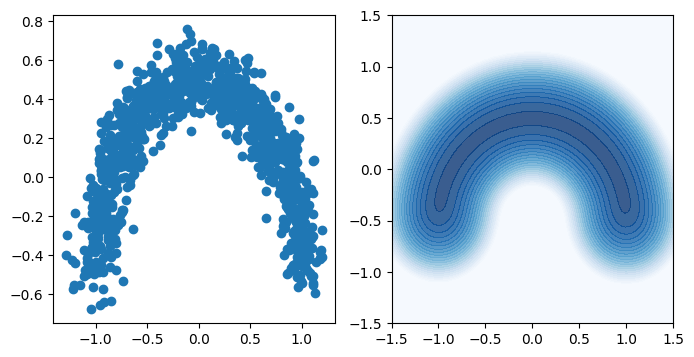

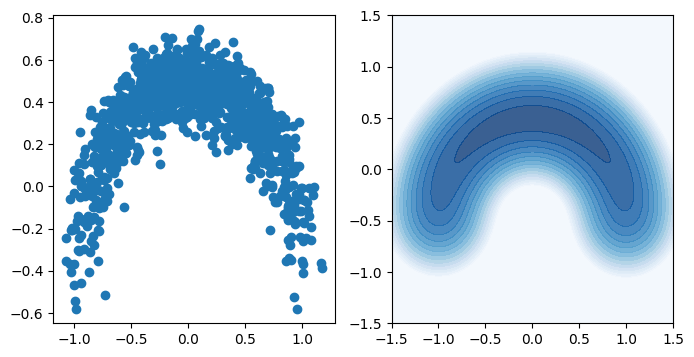

In [3]:
NB_GAUSSIANS = 200
RADIUS = 1
DEVICE = "cuda:1"
mean_ = (torch.linspace(0, 180, NB_GAUSSIANS + 1)[0:-1] * math.pi / 180)
MEAN = RADIUS * torch.stack([torch.cos(mean_), torch.sin(mean_)], dim=1) - torch.tensor([0.0,0.5])
COVAR = torch.tensor([[0.01, 0], [0, 0.01]]).unsqueeze(0).repeat(len(MEAN), 1, 1)

x_p, y_p = torch.meshgrid(torch.linspace(-1.5, 1.5, 100), torch.linspace(-1.5, 1.5, 100), indexing='xy')
pos = torch.cat([x_p.flatten().unsqueeze(1), y_p.flatten().unsqueeze(1)], dim=1).to(DEVICE)

## Gaussian Mixture Uniformly distributed
weight_1 = (torch.ones(NB_GAUSSIANS) / NB_GAUSSIANS)
mixture_1 = GaussianMixture(center_data=MEAN, covar=COVAR, weight=weight_1).to(DEVICE)


fig, ax = plt.subplots(1, 2, figsize=(2*4, 4), dpi=100)
sample_1 = mixture_1.sample(1000).cpu().detach()
#offset_1 = torch.tensor([0.0, 4.0])
#mult_1  = torch.tensor([10.0, 6.0])

energy_landscape_1 = mixture_1.energy(pos)

#sample_1_t = (sample_1-offset_1)/mult_1

mixture_sampling = GaussianMixture(center_data=MEAN, covar=COVAR*5, weight=weight_1).to(DEVICE)
ax[0].scatter(sample_1[:,0],sample_1[:,1])
im = ax[1].contourf(x_p, y_p, energy_landscape_1.view(100, 100).detach().cpu(), 20,
                        cmap='Blues_r',
                        alpha=0.8,
                        zorder=0,
                        levels=20)


plt.show()

## Gaussian Mixture non Uniformly distributed
linspace = torch.cat([torch.linspace(1, 30, 90),torch.ones(11)*30])
weight_2 = torch.cat([linspace, linspace[1:-1].flip(dims=(0,))])
weight_2 = weight_2/weight_2.sum()


linspace = torch.cat([torch.linspace(1, 30, 90),torch.ones(11)*30])



mixture_2 = GaussianMixture(center_data=MEAN, covar=COVAR, weight=weight_2).to(DEVICE)
energy_landscape_2 = mixture_2.energy(pos)

fig, ax = plt.subplots(1, 2, figsize=(2*4, 4), dpi=100)
sample_2 = mixture_2.sample(1000).cpu().detach()
#mean_mix2 = sample_2.mean()
#std_mix2 = sample_2.std()
ax[0].scatter(sample_2[:,0],sample_2[:,1])
im = ax[1].contourf(x_p, y_p, energy_landscape_2.view(100, 100).detach().cpu(), 20,
                        cmap='Blues_r',
                        alpha=0.8,
                        zorder=0,
                        levels=20)
plt.show()

In [4]:
## Set the netowrk architecture
class MLP_ELU_convex(nn.Module):
    def __init__(self):
        super(MLP_ELU_convex, self).__init__()
        self.f = nn.Sequential(
            nn.Linear(2, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 32)
            )
        self.f1 = nn.Linear(32, 1)
        self.f2 = nn.Linear(32, 1)
        self.f3 = nn.Linear(32, 1)
    
    def forward(self, x):
        out_feat = self.f(x)
        energy = self.f1(out_feat)*self.f2(out_feat) + self.f3(out_feat**2)
        return energy

## sgld sampler 
def sgld(en, x_i, n_steps=20, sgld_lr=100, sgld_std=1e-2):
    x_s = x_i.clone()
    #x_s = 5*torch.randn_like(x) + torch.tensor([0, 5]).unsqueeze(0).to(x.device)
    x_s.requires_grad_(True)
    for i in range(n_steps):
        e = en(x_s)
        grad_x = torch.autograd.grad(
            outputs=e, 
            inputs=x_s,
            grad_outputs=torch.ones_like(e),  # same shape as f
            create_graph=True,
            retain_graph=True
            )[0]
        
        x_s.data = x_s.data - sgld_lr * grad_x + sgld_std * torch.randn_like(x_s)
    final_samples = x_s.detach()
    return final_samples

## Train the EBM on the Uniformly distributed Gaussian mixture

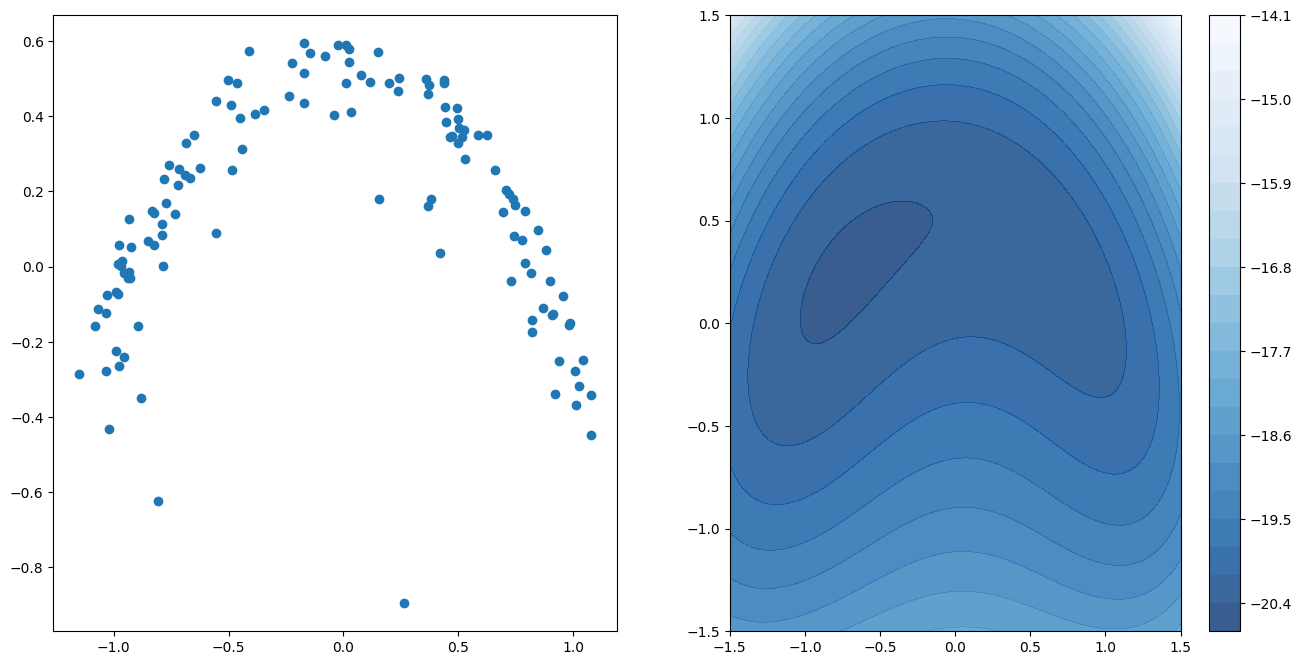

In [9]:
## Network 
SGLD_STEPS = 100
SGLD_STD = 1e-2
SGLD_LR = 1e-2
EPOCH = 10000
BATCH_SIZE=128
netE = MLP_ELU_convex().to(DEVICE)
en = lambda x: netE(x) 

train_EBM=False
if train_EBM:
    optimizer = torch.optim.Adam(netE.parameters(), lr=1e-4)
        
    all_loss = []
    for i in range(EPOCH):
        optimizer.zero_grad()
        #x = (mixture_1.sample(BATCH_SIZE) - mean_mix1)/std_mix1
        x = mixture_1.sample(BATCH_SIZE)
        
        x_i = torch.randn_like(x)
        x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
        
        fp_all = en(x)
        fq_all = en(x_s)
        
        fp = fp_all.mean()
        fq = fq_all.mean()
        l_p_x = fp - fq
        
        
        loss = l_p_x
        loss.backward()
        optimizer.step()
        
        all_loss.append(loss.item())
        if i % 10 ==0 :
            print(f"{i} -- loss : {loss.item():0.6f}")
        if i % 500 == 0 or i == EPOCH-1:
        
            x_i = torch.randn_like(x)
            x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
            all_e = en(pos)
            fig, ax = plt.subplots(1, 3, figsize=(3*8,8))
            ax[0].plot(all_loss)
            ax[1].scatter(x_s[:,0].cpu().detach(), x_s[:,1].cpu().detach())
            im = ax[2].contourf(x_p, y_p, all_e.view(100,100).detach().cpu(), 20, cmap='Blues_r', alpha=0.8, zorder=0, levels=20)
            fig.colorbar(im, ax=ax[2])
            plt.show()
    to_save = {"weight": netE.state_dict(),
               "type": type(netE)}
    torch.save(to_save, f"./EBM_Uniform_CD.pth")
else:
    ckpt = torch.load(f"./EBM_Uniform_CD.pth", weights_only=False)
    netE.load_state_dict(ckpt["weight"], strict=True)
    en = lambda x: netE(x)
    x_i = torch.randn(BATCH_SIZE, 2).to(DEVICE)
    x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
    #x_p, y_p = torch.meshgrid(torch.linspace(-5, 5, 100), torch.linspace(-5, 5, 100), indexing='xy')
    #pos = torch.cat([x_p.flatten().unsqueeze(1), y_p.flatten().unsqueeze(1)], dim=1).to(DEVICE)
    all_e = en(pos)
    fig, ax = plt.subplots(1, 2, figsize=(2*8,8))
    ax[0].scatter(x_s[:,0].cpu().detach(), x_s[:,1].cpu().detach())
    im = ax[1].contourf(x_p, y_p, all_e.view(100,100).detach().cpu(), 20, cmap='Blues_r', alpha=0.8, zorder=0, levels=20)
    fig.colorbar(im, ax=ax[1])
    plt.show()
    

In [ ]:
## Train the EBM on the non Uniformly distributed Gaussian mixture

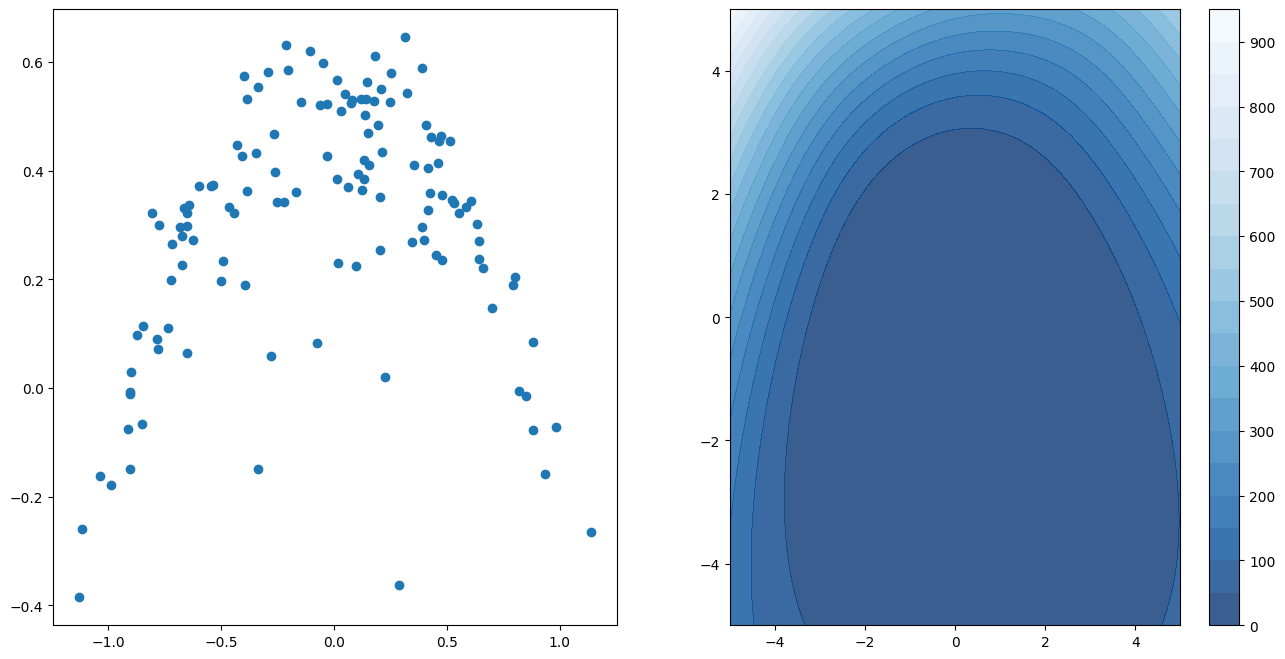

In [12]:
## Network 
SGLD_STEPS = 100
SGLD_STD = 1e-2
SGLD_LR = 1e-2
EPOCH = 10000
BATCH_SIZE=128
netE = MLP_ELU_convex().to(DEVICE)
en = lambda x: netE(x) 

train_EBM=False
if train_EBM:
    optimizer = torch.optim.Adam(netE.parameters(), lr=1e-4)
        
    all_loss = []
    for i in range(EPOCH):
        optimizer.zero_grad()
        x = mixture_2.sample(BATCH_SIZE)
        
        x_i = torch.randn_like(x)
        x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
        
        fp_all = en(x)
        fq_all = en(x_s)
        
        fp = fp_all.mean()
        fq = fq_all.mean()
        l_p_x = fp - fq
        
        
        loss = l_p_x
        loss.backward()
        optimizer.step()
        
        all_loss.append(loss.item())
        if i % 10 ==0 :
            print(f"{i} -- loss : {loss.item():0.6f}")
        if i % 2000 == 0 or i == EPOCH-1:
        
            x_i = torch.randn_like(x)
            x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
            all_e = en(pos)
            fig, ax = plt.subplots(1, 3, figsize=(3*8,8))
            ax[0].plot(all_loss)
            ax[1].scatter(x_s[:,0].cpu().detach(), x_s[:,1].cpu().detach())
            im = ax[2].contourf(x_p, y_p, all_e.view(100,100).detach().cpu(), 20, cmap='Blues_r', alpha=0.8, zorder=0, levels=20)
            fig.colorbar(im, ax=ax[2])
            plt.show()
    to_save = {"weight": netE.state_dict(),
               "type": type(netE)}
    torch.save(to_save, f"./EBM_non_Uniform_CD.pth")
else:
    ckpt = torch.load(f"./EBM_non_Uniform_CD.pth", weights_only=False)
    netE.load_state_dict(ckpt["weight"], strict=True)
    x_i = torch.randn_like(x)
    x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
    x_p, y_p = torch.meshgrid(torch.linspace(-5, 5, 100), torch.linspace(-5, 5, 100), indexing='xy')
    pos = torch.cat([x_p.flatten().unsqueeze(1), y_p.flatten().unsqueeze(1)], dim=1).to(DEVICE)
    all_e = en(pos)
    fig, ax = plt.subplots(1, 2, figsize=(2*8,8))
    ax[0].scatter(x_s[:,0].cpu().detach(), x_s[:,1].cpu().detach())
    im = ax[1].contourf(x_p, y_p, all_e.view(100,100).detach().cpu(), 20, cmap='Blues_r', alpha=0.8, zorder=0, levels=20)
    fig.colorbar(im, ax=ax[1])
    plt.show()
    